**todo**

- analise sentimento

- ~~ner + conceitos~~

- tentar newsVSprice de novo, agora com menos noticias

- qty de noticias por newsSource

- word cloud com cores de cada empresa

# NER aos dados

In [82]:
import pandas as pd
import spacy

df = pd.read_parquet("data04.parquet")

# Load the Portuguese model
nlp = spacy.load("pt_core_news_sm")


dict = df.iloc[2,1][3]

def NER_KEYWORDS(dict):
    # Process the text
    text = dict["ExtractedText"]
    doc = nlp(text)

    meses = {"janeiro", "fevereiro", "março", "abril", "maio", "junho",
             "julho", "agosto", "setembro", "outubro", "novembro", "dezembro"}
    dias_da_semana = {"segunda-feira", "terça-feira", "quarta-feira",
                      "quinta-feira", "sexta-feira", "sábado", "domingo", "fim-de-semana"}
    noticias = {"comentários", "notícias", "artigo", "jornal", "assine", "facebook", "assinaturas",
                "online", "twitter", "instagram", "linkedin", "whatsapp", "telegram", "youtube",
                "início", "partilhar", "contactos", "newsletter", "enviar", "termos", "privacidade",
                "iniciar", "inicie", "sessão", "subscrever", "subscreva", "subscrever", "tv", "rádio"}
    # Extract named entities and filter keywords
    named_entities = [
        (ent.text, ent.label_) for ent in doc.ents
        if ent.label_ in {"PER", "ORG", "LOC", "MISC"}
        and ent.text.lower() not in meses
        and ent.text.lower() not in dias_da_semana
        and all(w not in ent.text.lower() for w in noticias)
        and ent.text.isalnum()
    ]
    palavras_significativas = [
        token.text for token in doc 
        if token.pos_ in {"NOUN"} # {"NOUN", "VERB", "PROPN"} 
        and not token.is_stop
        and (token.text.islower() or token.text.isupper())
        and token.text.lower() not in meses 
        and token.text.lower() not in dias_da_semana
        and token.text.lower() not in noticias
        and token.text.isalnum()
        and len(token.text) > 3
    ]

    organized_entities = {}
    for entity, category in named_entities:
        if category not in organized_entities:
            organized_entities[category] = [entity]
        else:
            organized_entities[category].append(entity)
 
    dict["newsNER"] = organized_entities
    dict["newsNER"]["WORD"] =  palavras_significativas
    return dict

#NER_KEYWORDS(dict)


# analise de sentimentos

**por acabar**

In [83]:
import random
def sentimentos(dict):
    """analise de sentimentos ficticia"""
    text = dict["ExtractedText"]
    # ...
    dict["newsSentiment"] = random.random()
    return dict

# processar das noticias

In [84]:
def ProcCol(list):
    for i in range(len(list)):
        list[i] = NER_KEYWORDS(list[i])
        list[i] = sentimentos(list[i])
    return list

df["news"] = df["news"].map(ProcCol)

In [85]:
#df["news"].iloc[0][0]

---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---
---


### nota:

devo guardar os sites do arquivo, pode ser curioso ver de onde vêm certas palavras ou assim

In [86]:
def keywords(lista, lower = 0.1):
    ner = {}
    for news in lista:
        keywords = news["newsNER"]
        sentiment = news["newsSentiment"]
        for type, words in keywords.items():
            for word in words:
                # normalizar word
                if word.lower() in ner:
                    word = word.lower()
                elif word.title() in ner:
                    word = word.title()
                elif word.upper() in ner:
                    word = word.upper()

                # adicionar word
                if word in ner:
                    ner[word]["count"] += 1
                    ner[word]["sentiment"] = ((ner[word]["sentiment"] * (ner[word]["count"] - 1)) + sentiment) / ner[word]["count"]
                    ner[word]["type"].add(type)
                    if news["newsSource"] not in ner[word]["source"]:
                        ner[word]["source"][news["newsSource"]] = 1
                    else:
                        ner[word]["source"][news["newsSource"]] += 1
                    ner[word]["news"].add(news["linkToArchive"])

                else: #not seen
                    ner[word] = {"count": 1,
                                 "sentiment": sentiment,
                                 "type": {type},
                                 "source": {news["newsSource"]: 1},
                                 "news": {news["linkToArchive"]}}

                    # criar entrada do dicionario chamada weight q se sobrepoes a contagem: ex.: probnew = 0.6 ent weight = count*1.1
                    #       tbm variar consoante o type, se é WORD ou dos outros
                    # tbm devia remover urls que sao iguais e so muda a data do upload
    
    qtyNews = len(lista)
    filtered_ner = {word: data for word, data in ner.items() if data["count"] >= qtyNews * lower}

    return filtered_ner

#keywords(df["news"].iloc[0])
df["keywords"] = df["news"].map(keywords)
df["keywords"].iloc[0]

{'DN': {'count': 100,
  'sentiment': 0.5268485303672867,
  'type': {'ORG'},
  'source': {'Diário de Notícias': 99, 'RTP': 1},
  'news': {'https://arquivo.pt/wayback/20010913052557/http://www.dn.pt/int/13p4x.htm',
   'https://arquivo.pt/wayback/20020628034752/http://www.dn.pt/dn2/eco/28p43w.htm',
   'https://arquivo.pt/wayback/20110119093407/http://www.dn.pt/especiais/interior.aspx?content_id=1733893&especial=WikiLeaks&seccao=MUNDO',
   'https://arquivo.pt/wayback/20110119094255/http://www.dn.pt/especiais/interior.aspx?content_id=1733537&especial=WikiLeaks&seccao=MUNDO',
   'https://arquivo.pt/wayback/20110119095723/http://www.dn.pt/especiais/interior.aspx?content_id=1735059&especial=WikiLeaks&seccao=MUNDO',
   'https://arquivo.pt/wayback/20110127144421/http://www.dn.pt/inicio/interior.aspx?content_id=638225',
   'https://arquivo.pt/wayback/20110131014854/http://www.dn.pt/especiais/interior.aspx?content_id=1734048&especial=WikiLeaks&seccao=MUNDO',
   'https://arquivo.pt/wayback/20110211

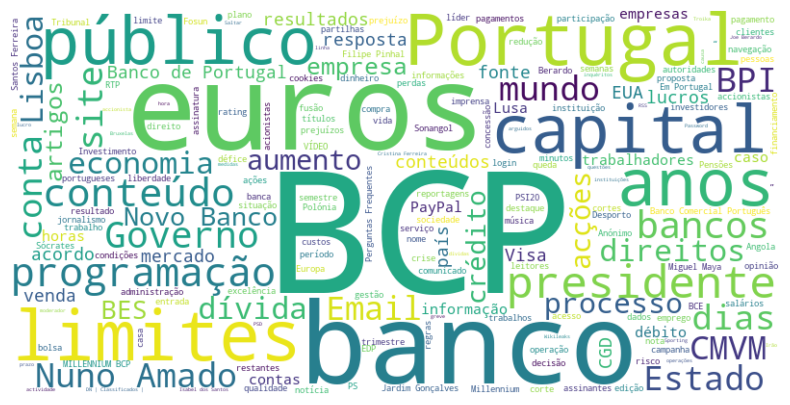

In [96]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# dar prioridade as nao palavras, arranjar um peso para as palavras
# normalizar as contagens/pesos, tlvz fazer um logaritmo ou assim
word_freq = {word: data["count"] for word, data in df["keywords"].iloc[0].items()}

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [88]:
import matplotlib.pyplot as plt


import plotly.graph_objects as go


frequencias = {word: data["count"] for word, data in df["keywords"].iloc[0].items()}

#frequencias = {k: v for k, v in frequencias.items() if v > 55}#in set(range(50, 1500))} #max e min pode ser tendo em conta qty de noticias

palavras = list(frequencias.keys())
valores = list(frequencias.values())

fig = go.Figure(data=[go.Bar(x=palavras, y=valores)])

fig.update_layout(
    title='Gráfico de Barras Interativo',
    xaxis_title='Palavras',
    yaxis_title='Frequência',
)

fig.show()


In [89]:
import numpy as np

min_val = min(set(frequencias.values()))
max_val = max(set(frequencias.values()))
mean_val = np.mean(list(frequencias.values()))
median_val = np.median(list(frequencias.values()))
count_val = np.count_nonzero(np.array(list(frequencias.values())) > 10)

min_val, max_val, mean_val, median_val, count_val, len(set(list(frequencias.keys())))


(81, 5170, np.float64(217.27364864864865), np.float64(138.0), 296, 296)

In [90]:
"Público" in frequencias

False

In [91]:
"PÚBLICO" in frequencias

False